In [39]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess



In [40]:
holidays_events = pd.read_csv(
    "holidays_events.csv",
    dtype={      #specify dtype to optimize memory usage
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [51]:
store_sales

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

In [49]:
type(average_sales)

pandas.core.series.Series

In [50]:
average_sales

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 227, dtype: float32

In [41]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [54]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False


In [52]:
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

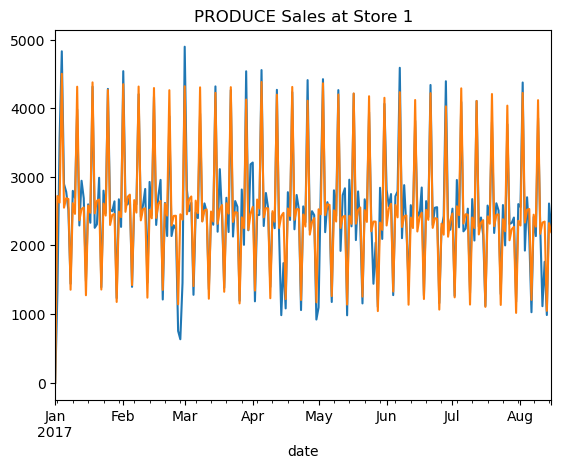

In [44]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
#display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot()
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [45]:
df_test = pd.read_csv( 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [53]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,False
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,False
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,False
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,False
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,False
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347,False
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653,False
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964,False
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530,False


In [46]:
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.274030
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.495530
                     BEVERAGES                   3000891  2414.541711
                     BOOKS                       3000892     0.438314
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   372.417153
                     PREPARED FOODS              3029396   107.843530
                     PRODUCE                     3029397  1273.316507
                     SCHOOL AND OFFICE SUPPLIES  3029398    44.945937
                     SEAFOOD                     3029399    18.946715

[28512 rows x 2 columns]

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.




If RMSLE < 1: The model's predictions are relatively close to the actual values on a logarithmic scale. This indicates good performance.


If RMSLE ≈ 1: The model's predictions are somewhat close to the actual values, but there is room for improvement.


If RMSLE > 1: The model's predictions deviate significantly from the actual values on a logarithmic scale. This indicates poor performance.